# Model for aimpoint drift (aka ACA alignment drift)

This notebook documents and computes fit coefficients for a simple model that
gives the relative ACA alignment as a linear function of the ACA housing temperature.

The ACA alignment is measured accurately each science observation via the apparent
positions of the fid lights.  These are referred to by their CXC aspect solution
designation as the SIM DY and DZ offsets.  This is actually a misnomer based on
the pre-launch understanding of what physical mechanism would generate such offsets.
We now know via HRMA optical axis measurements that a temperature-dependent change 
in the ACA boresight alignment is responsible.  The HRMA to SIM alignment is quite
stable.

The ACA alignment relates directly to the X-ray detector aimpoint that is used in
observation planning and analysis.  With this model it will be possible to improve
the aimpoint accuracy by introducing a dynamic pointing offset based on the
predicted ACA temperature for each observation.

The model is
```
DY/Z = (AACH1T - offset) * scale + (year - 2016.0) * trend + JUMPS
```
where
```
  AACH1T : Telemetry MSID for ACA housing temperature (degF)
  scale : scaling in arcsec / degF
  offset : ACA housing temperature corresponding to DY/Z = 0.0 arcsec
  trend : Trend in DY/Z (arcsec / year)
  year : decimal year
  jumpYYYYDDD : step function from 0.0 to jumpYYYYDDD (arcsec) for date > YYYY:DDD
```
The jumps are persistent step function changes in alignment that have been observed following
extended dwells at normal sun where the ACA gets substantially hotter than during
normal operations.  The exact mechanism is not understood, but could be due to
a non-linear stiction release of a stress point that impacts alignment.

This model was fitted to data from 2012:001 to 2016:050 using Sherpa.  The key fit results are:
```
DY
-----
scale = 2.0 arcsec / degF
trend = -1.2 arcsec / year
jumps ~ -4.5 to -5 arcsec

model error = +/- 1.6 arcsec (1st to 99th percentile range)

DZ
-----
scale = 1.0 arcsec / degF
trend = -0.3 arcsec / year
jumps ~ -0.5 to -2.0 arcsec

model error = +/- 2.7 arcsec (1st to 99th percentile range)

```

The model accuracy will be degraded somewhat when ACA housing temperature
is taken from a predictive Xija model instead of from telemetry.

*This notebook lives in the **aimpoint_mon** project repository*

## Code

In [1]:
import re
from itertools import izip

import tables
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
import Ska.engarchive.fetch_eng as fetch
from Ska.Numpy import interpolate
from sherpa import ui
from Ska.Matplotlib import plot_cxctime

In [2]:
%matplotlib inline

In [3]:
SIM_MM_TO_ARCSEC = 20.493

In [4]:
# Discrete jumps after 2012:001.  Note also jumps at:
#   '2008:293',  # IU-reset
#   '2010:151',  # IU-reset
#   '2011:190',  # Safe mode
JUMPS = ['2015:006',  # IU-reset
         '2015:265',  # Safe mode
         ]

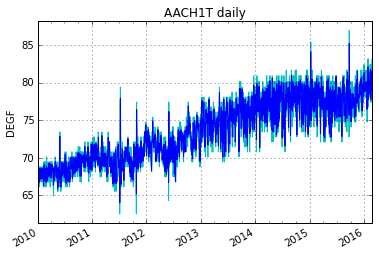

In [5]:
# Aspect camera housing temperature trend since 2010
aach1t = fetch.Msid('aach1t', start='2010:001', stat='daily')
aach1t.iplot()

In [6]:
# Get aspect solution DY and DZ (apparent SIM offsets via fid light positions)
# which are sampled at 1 ksec intervals and updated daily.
if 'adat' not in globals():
    h5 = tables.openFile('/proj/sot/ska/data/aimpoint_mon/aimpoint_asol_values.h5')
    adat = h5.root.data[:]
    h5.close()

    adat.sort(order=['time'])

    # Filter bad data when asol DY and DZ are both exactly 0.0 (doesn't happen normally)
    bad = (adat['dy'] == 0.0) & (adat['dz'] == 0.0)
    adat = adat[~bad]

In [7]:
class AcaDriftModel(object):
    """
    Class to encapsulate necessary data and compute the model of ACA
    alignment drift.  The object created from this class is called
    by Sherpa as a function during fitting.  This gets directed to
    the __call__() method.
    """
    YEAR0 = 2016.0  # Reference year for linear offset
    
    def __init__(self, adat, start='2012:001', stop=None):
        """
        adat is the raw data array containing aspect solution data
        sampled at 1 ksec intervals.
        """
        # Get the ACA housing temperature telemetry
        aach1t = fetch.Msid('aach1t', stat='5min', start=start, stop=stop)
        
        # Slice the ASOL data corresponding to available ACA housing temps
        i0, i1 = np.searchsorted(adat['time'], [aach1t.times[0], aach1t.times[-1]])
        self.asol = adat[i0:i1].copy()
        
        # Convert from mm to arcsec for convenience
        self.asol['dy'] *= SIM_MM_TO_ARCSEC
        self.asol['dz'] *= SIM_MM_TO_ARCSEC
        
        self.times = self.asol['time']
        self.years = Time(self.times, format='cxcsec').decimalyear
        self.years_0 = self.years - self.YEAR0
        
        # Resample housing temp. data to the 1 ksec ASOL time stamps
        self.aach1t = interpolate(aach1t.vals, aach1t.times, self.asol['time'], method='linear')
        
        # Get indices corresponding to jump times for later model computation
        self.jump_times = Time(JUMPS).cxcsec
        self.jump_idxs = np.searchsorted(self.times, self.jump_times)

    def __call__(self, pars, years=None, aach1t=None):
        """
        Calculate model prediction for DY or DZ.  Params are:
        
          scale : scaling in arcsec / degF
          offset : ACA housing temperature corresponding to DY/Z = 0.0 arcsec
          trend : Trend in DY/Z (arcsec / year)
          jumpYYYYDDD : discrete jump in arcsec at date YYYY:DDD
        """
        # Sherpa passes the parameters as a list
        scale, offset, trend = pars[0:3]
        jumps = pars[3:]
        
        # Allow for passing in a different value for ACA housing temperature
        if aach1t is None:
            aach1t = self.aach1t

        # Compute linear part of model
        out = (aach1t - offset) * scale + self.years_0 * trend

        # Put in the step function jumps
        for jump_idx, jump in izip(self.jump_idxs, jumps):
            if jump_idx > 10 and jump_idx < len(out) - 10:
                out[jump_idx:] += jump

        return out

In [8]:
def fit_aimpoint_aca_temp(axis='dy', start='2012:001', stop=None):
    """
    Use Sherpa to fit the model parameters
    """
    # Create the object used to define the Sherpa user model, then
    # load as a model and create parameters
    aca_drift = AcaDriftModel(adat, start, stop)
    ui.load_user_model(aca_drift, 'aca_drift_model')
    parnames = ['scale', 'offset', 'trend']
    parnames += ['jump{}'.format(re.sub(':', '', x)) for x in JUMPS]
    ui.add_user_pars('aca_drift_model', parnames)
    
    # Sherpa automatically puts 'aca_drift_model' into globals, but
    # make this explicit so code linters don't complain.
    aca_drift_model = globals()['aca_drift_model']

    # Get the DY or DZ values and load as Sherpa data
    dyz = aca_drift.asol[axis]
    ui.load_arrays(1, aca_drift.years, dyz)

    # Set the model and fit using Simplex (Nelder-Mead) minimization
    ui.set_model(1, aca_drift_model)
    ui.set_method('simplex')
    ui.fit(1)
    
    return aca_drift, ui.get_fit_results()    

In [9]:
def plot_aimpoint_drift(axis, aca_drift, fit_results):
    """
    Plot our results
    """
    # DY or DZ values from aspect solution
    dyz = aca_drift.asol[axis]
    
    # Call model directly with best-fit parameters to get model values
    dyz_fit = aca_drift(fit_results.parvals)
    dyz_resid = dyz - dyz_fit
    years = aca_drift.years
    times = aca_drift.times

    plt.figure(1)
    plt.clf()
    plot_cxctime(times, dyz, label='Data')
    plot_cxctime(times, dyz_fit, 'r-', alpha=0.5, label='Fit')
    plot_cxctime(times, dyz_resid, 'r-', label='Residual')
    plt.title('Fit aspect solution {} to scaled ACA housing temperature'
              .format(axis.upper()))
    plt.ylabel('{} (arcsec)'.format(axis.upper()))
    plt.grid()
    plt.legend(loc='upper left', framealpha=1.0)
    plt.draw()
    plt.show()
    
    std = dyz_resid.std()
    p1, p99 = np.percentile(dyz_resid, [1, 99])
    print('Fit residual stddev = {:.2f} arcsec'.format(std))
    print('Fit residual 99th - 1st percentile = {:.2f}'.format(p99 - p1))

## Fit model coefficients for DY and plot results

In [10]:
aca_drift_dy, fit_dy = fit_aimpoint_aca_temp('dy')

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 1.22535e+06
Final fit statistic   = 1964.56 at function evaluation 1219
Data points           = 102466
Degrees of freedom    = 102461
Probability [Q-value] = 1
Reduced statistic     = 0.0191737
Change in statistic   = 1.22339e+06
   aca_drift_model.scale   1.96787     
   aca_drift_model.offset   66.5124     
   aca_drift_model.trend   -1.17438    
   aca_drift_model.jump2015006   -4.40038    
   aca_drift_model.jump2015265   -4.79851    


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 1.22535e+06
Final fit statistic   = 1964.56 at function evaluation 1219
Data points           = 102466
Degrees of freedom    = 102461
Probability [Q-value] = 1
Reduced statistic     = 0.0191737
Change in statistic   = 1.22339e+06
   aca_drift_model.scale   1.96787     
   aca_drift_model.offset   66.5124     
   aca_drift_model.trend   -1.17438    
   aca_drift_model.jump2015006   -4.40038    
   aca_drift_model.jump2015265   -4.79851    


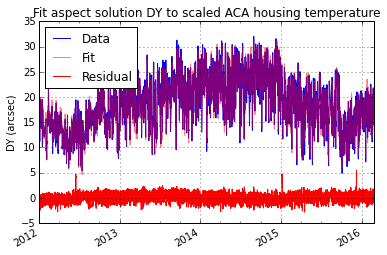

Fit residual stddev = 0.73 arcsec
Fit residual 99th - 1st percentile = 3.25


In [11]:
plot_aimpoint_drift('dy', aca_drift_dy, fit_dy)

### Illustrate model behavior by assuming a constant ACA housing temperature

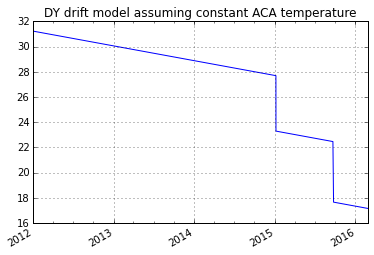

In [12]:
dyz_fit = aca_drift_dy(fit_dy.parvals, aach1t=80)
plot_cxctime(aca_drift_dy.times, dyz_fit)
plt.title('DY drift model assuming constant ACA temperature')
plt.ylim(16, 32)
plt.grid();

## Fit model coefficients for DZ and plot results

In [13]:
aca_drift_dz, fit_dz = fit_aimpoint_aca_temp('dz')

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 1.19027e+06
Final fit statistic   = 7178.98 at function evaluation 1271
Data points           = 102466
Degrees of freedom    = 102461
Probability [Q-value] = 1
Reduced statistic     = 0.0700655
Change in statistic   = 1.18309e+06
   aca_drift_model.scale   0.980041    
   aca_drift_model.offset   57.0687     
   aca_drift_model.trend   -0.268476   
   aca_drift_model.jump2015006   -1.98022    
   aca_drift_model.jump2015265   -0.411685   


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 1.19027e+06
Final fit statistic   = 7178.98 at function evaluation 1271
Data points           = 102466
Degrees of freedom    = 102461
Probability [Q-value] = 1
Reduced statistic     = 0.0700655
Change in statistic   = 1.18309e+06
   aca_drift_model.scale   0.980041    
   aca_drift_model.offset   57.0687     
   aca_drift_model.trend   -0.268476   
   aca_drift_model.jump2015006   -1.98022    
   aca_drift_model.jump2015265   -0.411685   


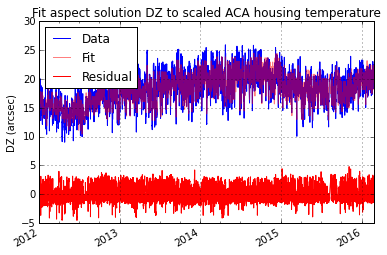

Fit residual stddev = 1.42 arcsec
Fit residual 99th - 1st percentile = 5.47


In [14]:
plot_aimpoint_drift('dz', aca_drift_dz, fit_dz)

### Illustrate model behavior by assuming a constant ACA housing temperature

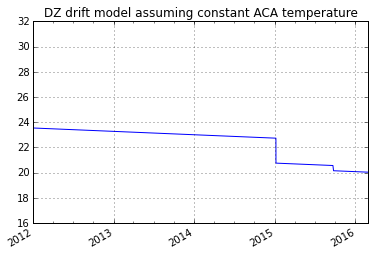

In [15]:
dyz_fit = aca_drift_dz(fit_dz.parvals, aach1t=80)
plot_cxctime(aca_drift_dz.times, dyz_fit)
plt.title('DZ drift model assuming constant ACA temperature')
plt.ylim(16, 32)
plt.grid();